In [60]:
from atl_module.geospatial_functions import make_gdf_from_ncdf_files
from atl_module.kde_peaks_method import get_elev_at_max_density,AccumulateKDEs
from atl_module.load_netcdf import load_beam_array_ncds
from atl_module import icesat_bathymetry
from atl_module.refraction_correction import correct_refr
from atl_module.raster_interaction import query_raster
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.pyplot import clf

In [73]:
atl03_testfile = "../data/test_sites/florida_keys/ATL03/processed_ATL03_20211130141337_10561301_005_01.nc"
beam = "gt2l"
beamdata =  load_beam_array_ncds(atl03_testfile, beam)

print(f"length of the dataset is {beamdata.shape[0]} points")
metadata_dict = beamdata.dtype.metadata

length of the dataset is 28817 points


In [189]:
raw_data = icesat_bathymetry.add_along_track_dist(beamdata)
# .pipe(point_dataframe_filters.add_sea_surface_level)
point_dataframe = icesat_bathymetry._filter_points(raw_data)    
point_dataframe = icesat_bathymetry.add_rolling_kde(point_dataframe,window=200)

true_bathy = query_raster(point_dataframe,src='../data/test_sites/florida_keys/in-situ-DEM/2019_irma.vrt')
point_dataframe = point_dataframe.assign(fema_elev = true_bathy,error=point_dataframe.z_kde-true_bathy)


thresholdval = point_dataframe.kde_val.median()-0*point_dataframe.kde_val.std()
print(thresholdval)
# point_dataframe.loc[(point_dataframe.kde_val < thresholdval),'z_kde'] = np.NaN

point_dataframe.count()


0.03992999830368171


X                   9011
Y                   9011
Z                   9011
Z_g                 9011
geoid_corr          9011
tide_ocean_corr     9011
geof2m_corr         9011
delta_time          9011
oc_sig_conf         9011
land_sig_conf       9011
p_vec_az            9011
p_vec_elev          9011
dist_or             9011
easting             9011
northing            9011
gebco_elev          9011
sea_level_interp    9011
Z_refr              9011
easting_corr        9011
northing_corr       9011
z_kde               8812
kde_val             8812
fema_elev           8149
error               8149
dtype: int64

<AxesSubplot:xlabel='xloc'>

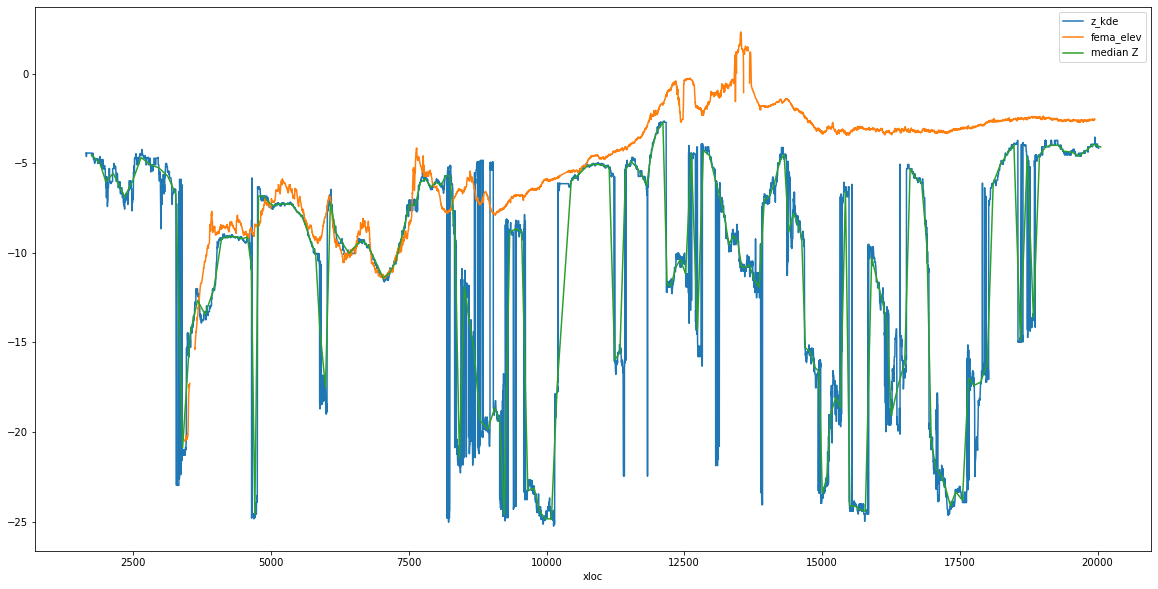

In [197]:
distlist = []
vertdistlist = []
pt_count = []
median_list = []
xloclist = []
errorlist = []
rangelist = []
maxslopelist = []
stdlist = []

for x,y in point_dataframe.groupby(np.arange(len(point_dataframe))//50):
    distlist.append(y.dist_or.max()-y.dist_or.min())
    vertdistlist.append(y.z_kde.max()-y.z_kde.min())
    pt_count.append(y.z_kde.count())
    median_list.append(y.z_kde.median())
    xloclist.append(y.dist_or.mean())
    errorlist.append(y.error.abs().mean())
    maxslopelist.append(df_slope(y).abs().max())
    stdlist.append(y.z_kde.std())

block_dict = {'distances':distlist,'vertical':vertdistlist,'Point count':pt_count,'median Z':median_list,'xloc':xloclist,'error':errorlist,'maxslope':maxslopelist,'stddev':stdlist}


df = pd.DataFrame(block_dict)
# df = df.assign(avgslope=df.vertical/df.distances)
# df = df[df.maxslope<30]
ax = point_dataframe.plot(x='dist_or',y='z_kde',figsize=(20,10))
point_dataframe.plot(x='dist_or',y='fema_elev',ax=ax)
df.plot(x='xloc',y='median Z',ax=ax)


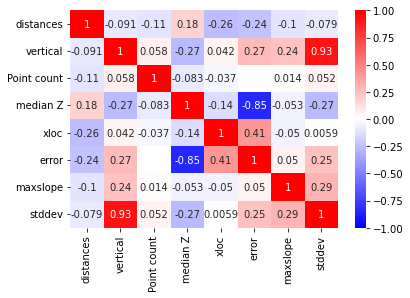

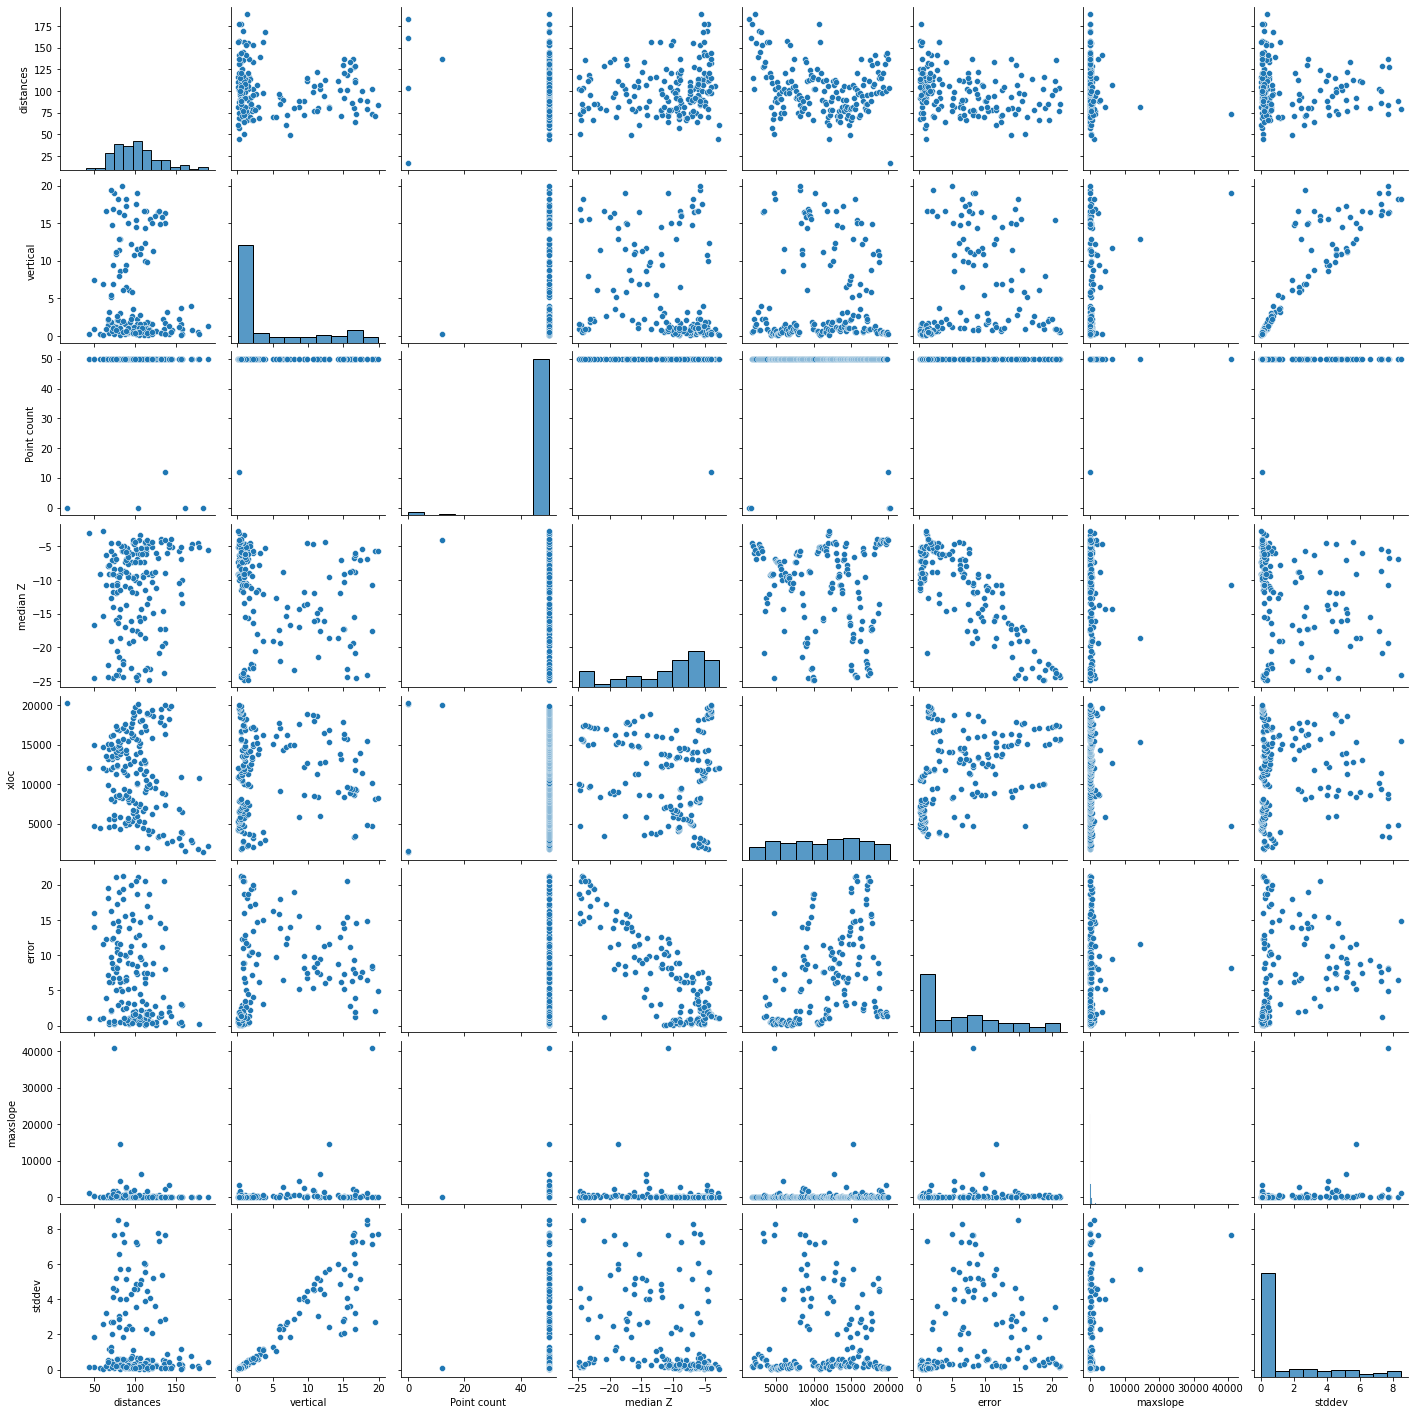

In [198]:
sns.heatmap(df.corr(),vmin=-1,vmax=1,cmap='bwr',annot=True)
sns.pairplot(df)

In [199]:
def df_slope(df):
    diff_df = df.loc[:,['dist_or','z_kde']].diff(1)

    slopes = diff_df.z_kde/diff_df.dist_or
    return slopes.dropna()

df_slope(point_dataframe)

2665     0.000000
2664     0.000000
2669    -0.066484
2675     0.029796
2677     0.000000
           ...   
28503   -0.065586
28509    0.000000
28515    0.000000
28519    0.000000
28521   -0.055011
Length: 8811, dtype: float64

In [202]:
point_dataframe.loc[:,['dist_or','z_kde']].dropna()

dist_or     z_kde
2659    1645.681478 -4.435146
2665    1648.531723 -4.435146
2664    1648.548137 -4.435146
2669    1651.414828 -4.625736
2675    1657.811338 -4.435146
...             ...       ...
28503  19997.247039 -4.088800
28509  20007.952688 -4.088800
28515  20012.976540 -4.088800
28519  20015.130221 -4.088800
28521  20016.534207 -4.166035

[8812 rows x 2 columns]

In [203]:
from atl_module.kde_peaks_method import get_elev_at_max_density

# testindexer = VariableOffsetWindowIndexer(index=point_dataframe.dist_or)
# What is the most and least distance a window can cover?
def rollfunc(df):
    print(df)
    return 1
point_dataframe.rolling(window=5).apply(rollfunc)

2178   -80.922033
2182   -80.922032
2188   -80.922042
2189   -80.922040
2193   -80.922039
dtype: float64
2182   -80.922032
2188   -80.922042
2189   -80.922040
2193   -80.922039
2194   -80.922045
dtype: float64
2188   -80.922042
2189   -80.922040
2193   -80.922039
2194   -80.922045
2198   -80.922046
dtype: float64
2189   -80.922040
2193   -80.922039
2194   -80.922045
2198   -80.922046
2200   -80.922041
dtype: float64
2193   -80.922039
2194   -80.922045
2198   -80.922046
2200   -80.922041
2203   -80.922044
dtype: float64
2194   -80.922045
2198   -80.922046
2200   -80.922041
2203   -80.922044
2204   -80.922051
dtype: float64
2198   -80.922046
2200   -80.922041
2203   -80.922044
2204   -80.922051
2209   -80.922048
dtype: float64
2200   -80.922041
2203   -80.922044
2204   -80.922051
2209   -80.922048
2221   -80.922056
dtype: float64
2203   -80.922044
2204   -80.922051
2209   -80.922048
2221   -80.922056
2244   -80.922074
dtype: float64
2204   -80.922051
2209   -80.922048
2221   -80.922056
2

KeyboardInterrupt: 

In [ ]:
ax = df.plot.scatter(x='dist_or',y='Z_g',alpha=0.2,figsize=(20,10))
df.plot(x='dist_or',y='z_kde',ax=ax,c='orange')
df.plot(x='dist_or',y='sea_level_interp',ax=ax)
df.plot(x='dist_or',y='upperlim',ax=ax)
df.plot(x='dist_or',y='lowerlim',ax=ax)

In [ ]:
ax2 = df.plot(x='dist_or',y='kde_val',figsize=(20,10))
# ax2.axhline(df.kde_val.mean())
ax2.axhline(thresholdval)


In [ ]:
df = df.assign(rolling_kde_mean = df.kde_val.rolling(window=2000,center=True).mean(),rolling_kde_std = df.kde_val.rolling(window=2000,center=True).std())

In [ ]:
ax3 = df.plot(x='dist_or',y='kde_val',figsize=(20,10))
# df.plot(x='dist_or',y='rolling_kde_std',figsize=(20,10),ax=ax3)
df = df.eval('threshhold_kde_val = rolling_kde_mean-1*rolling_kde_std')
df.plot(x='dist_or',y='threshhold_kde_val',figsize=(20,10),ax=ax3)
# df.plot(x='dist_or',y='rolling',figsize=(20,10),ax=ax3)


In [ ]:
def add_kde_info(df):    
    # set up the object to keep all the return values
    accumulator = AccumulateKDEs()
    # this series is a key to matching the KDE value and the Z elevation of the Max KDE to the points in original df
    # this is a complicated series of joins but it should support matching any arbitrary indexes
    series_out = (
        # apply the function from the object
        df.Z_g.rolling(window=200, center=True)
        .apply(accumulator.calc_kdeval_and_zval, raw=True)
        .dropna()
        .astype("int")
    )
    # rename the series so the merge works
    series_out.name = "matchup"
    kdevals_df = pd.DataFrame(accumulator.returndict).set_index("matchup")
    merge_df = (
        pd.DataFrame(series_out)
        .merge(kdevals_df, left_on="matchup", right_index=True)
        .drop(columns="matchup")
    )
    df_w_kde = df.merge(merge_df,right_index=True,left_index=True,how='left')
    # make sure we didn't lose anything
    assert df_w_kde.shape[0] == df.shape[0]
    return df_w_kde